In [1]:
SEED = 42 
import numpy.random
import random
numpy.random.seed(SEED)
random.seed(SEED)


from ema_workbench import (Model, RealParameter, Policy, Constant, Scenario, ScalarOutcome)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (MultiprocessingEvaluator, ema_logging, perform_experiments) # parallel computing

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline  
# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.


ema_logging.log_to_stderr(ema_logging.INFO)

'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''

dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id


C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
import functools

# percentile90 = functools.partial(np.percentile, q=90)

# def var_mean(data):
#     return ((np.percentile(data,q=75)-np.percentile(data,q=25))*np.sum(data)/(data.shape[0]))

def mean_rob(data):
    return np.sum(data)/(data.shape[0]*1e9)

def threshold(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE 

SMALLER = "SMALLER"

death_funcs = functools.partial(threshold, SMALLER, 0.05)
damage_funcs = functools.partial(threshold, SMALLER, 100000)

robustness_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE,
                             variable_name='Expected Number of Deaths', function = death_funcs),
                        ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE,
                             variable_name='Expected Annual Damage', function = damage_funcs),
                        ScalarOutcome('Total Investment Costs', kind=MINIMIZE,
                             variable_name='Total Investment Costs', function = mean_rob)]

# Expected Annual Damage
# RfR Investment Costs
# Evacuation Costs
# Expected Number of Deaths
# Total Investment Costs


In [3]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 60
scenarios = sample_uncertainties(dike_model, n_scenarios)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/200 nfe
[MainProcess/INFO] optimization completed, found 4 solutions
[MainProcess/INFO] terminating pool


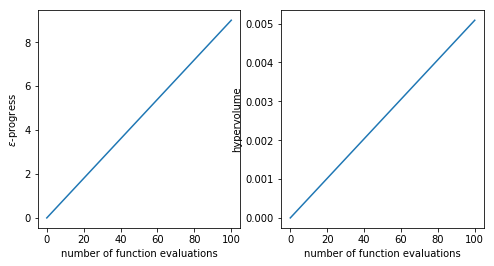

Wall time: 4h 9min 40s


In [4]:
%%time

from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1

ema_logging.log_to_stderr(ema_logging.INFO)

nfe = 200

epsilon = [0.1, 0.1, 0.1]


convergence_metrics = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 3, 1.1]),
                       EpsilonProgress()]
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustness_functions, scenarios,
                            nfe=nfe, convergence=convergence_metrics, epsilons=epsilon)
#start = time.time()
archive.to_csv("ArchiveRobustOptimizationMoro60scen200nfe")
convergence.to_csv("ConvergenceRobustOptimizationMoro60scen200nfe")
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()